# How to use iso-probabilistic transformations to obtain weather-corrleated spot markets with a desired distribution

In [2]:
# Install hydesign if needed
import importlib
if not importlib.util.find_spec("hydesign"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/hydesign.git   

In [3]:
import numpy as np
from numpy import newaxis as na
import pandas as pd
import scipy
from statsmodels.distributions.empirical_distribution import ECDF, monotone_fn_inverter
from hydesign.weather.weather import isoprob_transfrom
from hydesign.examples import examples_filepath

In [4]:
inputs = pd.read_csv(examples_filepath+'Europe/GWA2/input_ts_Denmark_good_solar.csv',
                    index_col=0, parse_dates = True)
inputs

,WS_1,WS_50,WS_100,WS_150,WS_200,WD_1,WD_50,WD_100,WD_150,WD_200,temp_air_1,ghi,dni,dhi,Price
2012-01-01 00:00:00,2.810816,6.582182,7.993129,8.112989,9.236903,166.346357,168.595724,170.888214,173.593446,175.457612,275.686735,0.0,0.0,0.0,31.558
2012-01-01 01:00:00,2.904450,6.810934,8.275190,8.356479,9.566073,169.298921,171.004601,172.747782,175.411415,176.846748,275.846921,0.0,0.0,0.0,31.558
2012-01-01 02:00:00,2.991752,6.987023,8.481921,8.563847,9.907062,170.332390,172.071325,173.846343,176.856068,178.182438,275.908146,0.0,0.0,0.0,31.558
2012-01-01 03:00:00,3.081025,7.153487,8.673896,8.668350,10.113215,172.369415,174.117329,175.900884,179.006964,180.215424,275.985910,0.0,0.0,0.0,31.558
2012-01-01 04:00:00,3.032618,7.087701,8.604443,8.657067,10.226668,176.961308,179.096749,181.275850,185.728569,187.114208,276.139611,0.0,0.0,0.0,31.558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-30 19:00:00,4.346459,9.731132,11.725017,11.833588,13.738749,232.070531,233.096306,234.139569,235.862549,236.381657,276.787589,0.0,0.0,0.0,34.992
2012-12-30 20:00:00,4.351285,9.781253,11.793128,11.924614,13.851638,236.280844,237.063277,237.866713,239.526916,239.919572,276.550026,0.0,0.0,0.0,33.135
2012-12-30 21:00:00,4.131801,9.349829,11.286007,11.395169,13.252576,234.027128,235.111454,236.219895,237.857080,238.418164,276.707764,0.0,0.0,0.0,32.290
2012-12-30 22:00:00,4.226335,9.590430,11.581791,11.705639,13.626405,231.547924,233.116758,234.719448,236.786499,237.542031,276.996122,0.0,0.0,0.0,30.990


## 1. Sample a target distrubtion, the number of samples can be different between input data and desired distribution

In [5]:
#y_desired = np.random.normal(size=int(1e6)) * 5 + 35

y_desired = np.random.weibull(a=2, size=int(1e6)) * 25 + 18

In [6]:
y_ISO = isoprob_transfrom(y_input=inputs.Price.values, y_desired=y_desired)

In [7]:
from matplotlib import pyplot as plt

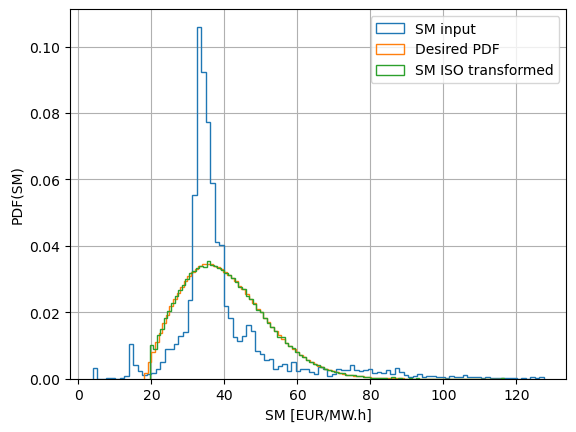

In [8]:
inputs.Price.hist(bins=100, histtype='step', density=True, label = 'SM input')
plt.hist(y_desired,bins=100, histtype='step', density=True, label = 'Desired PDF')
plt.hist(y_ISO,bins=100, histtype='step', density=True, label = 'SM ISO transformed')
plt.xlabel('SM [EUR/MW.h]')
plt.ylabel('PDF(SM)')
plt.legend()
print()

In [9]:
inputs['SM_ISO'] = y_ISO

In [10]:
inputs.loc[:,['Price','SM_ISO']].describe()

,Price,SM_ISO
count,8760.000000,8760.000000
mean,39.597426,40.163983
std,14.988624,11.596071
min,3.946000,19.546135
25%,32.804000,31.443554
50%,35.428500,38.809106
75%,41.028500,47.409729
max,127.491000,116.739295


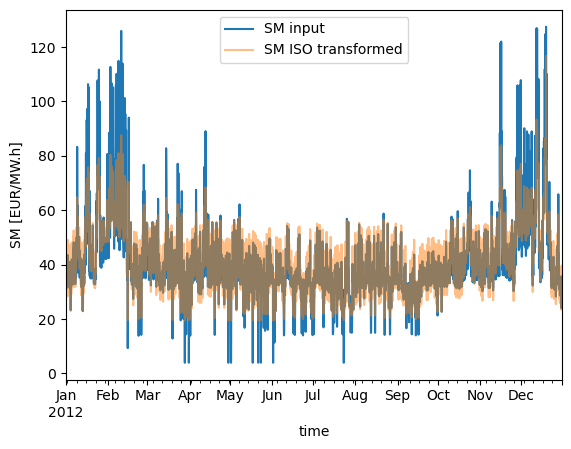

In [11]:
inputs.Price.plot(label = 'SM input')
inputs.SM_ISO.plot(alpha=0.5, label = 'SM ISO transformed')
plt.ylabel('SM [EUR/MW.h]')
plt.xlabel('time')
plt.legend()
print()

In [12]:
inputs.loc[:,['WS_100','Price','SM_ISO']].corr()

,WS_100,Price,SM_ISO
WS_100,1.000000,-0.272191,-0.289814
Price,-0.272191,1.000000,0.914723
SM_ISO,-0.289814,0.914723,1.000000


In [15]:
inputs['ws_bin'] = pd.cut(inputs.WS_100, bins=np.arange(0,20,1))

inputs_grp = inputs.groupby('ws_bin', observed=False).mean()

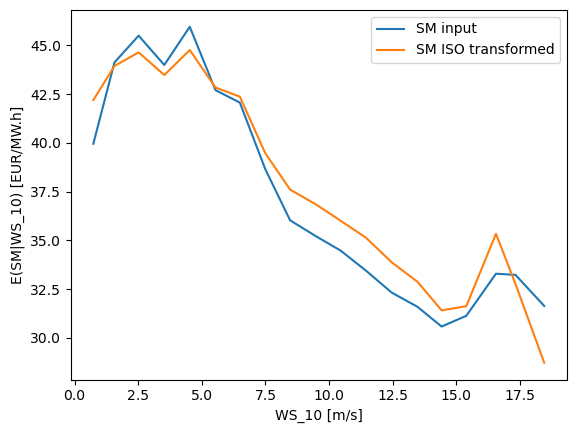

In [16]:

plt.plot(inputs_grp.WS_100.values, inputs_grp.Price.values, label = 'SM input')
plt.plot(inputs_grp.WS_100.values, inputs_grp.SM_ISO.values, label = 'SM ISO transformed')
plt.legend()

plt.ylabel(r'E(SM|WS_10) [EUR/MW.h]')
plt.xlabel('WS_10 [m/s]')

print()

In [17]:
import scipy.stats as st
def kde_plot(
    x,y,
    ax,
    c='k',
    levels = [1e-5, 5e-5, 1e-4, 5e-4],
    fmt = '%1.0e',
    ):
    xmin = np.min(x) 
    xmax = np.max(x)
    ymin = np.min(y) 
    ymax = np.max(y)

    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # Contour plot
    cset = ax.contour(xx, yy, f, levels=levels, colors=c)
    artists, labels = cset.legend_elements()

    ax.clabel(cset, inline=1, fontsize=10, fmt = fmt)
    return artists[0]
    

Text(0.5, 0, 'WS_10 [m/s]')

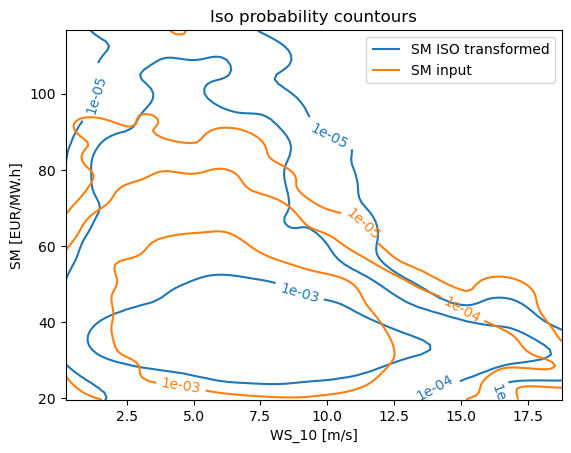

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
a1 = kde_plot(x=inputs.WS_100.values, y=inputs.Price.values, ax=ax, levels = [1e-5, 1e-4, 1e-3], c='C0')
a2 = kde_plot(x=inputs.WS_100.values, y=inputs.SM_ISO.values, ax=ax, levels = [1e-5, 1e-4, 1e-3], c='C1')
plt.legend(handles = [a1, a2], labels= ['SM ISO transformed', 'SM input'])
plt.title('Iso probability countours')
plt.ylabel('SM [EUR/MW.h]')
plt.xlabel('WS_10 [m/s]')    